<a href="https://colab.research.google.com/github/Tristan-Brown1096/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [19]:
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df = df[df['SALE_PRICE'] > 100000]
df = df[df['SALE_PRICE'] < 2000000]

#EDA

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151 entries, 44 to 23035
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         3151 non-null   object        
 1   NEIGHBORHOOD                    3151 non-null   object        
 2   BUILDING_CLASS_CATEGORY         3151 non-null   object        
 3   TAX_CLASS_AT_PRESENT            3151 non-null   object        
 4   BLOCK                           3151 non-null   int64         
 5   LOT                             3151 non-null   int64         
 6   EASE-MENT                       0 non-null      float64       
 7   BUILDING_CLASS_AT_PRESENT       3151 non-null   object        
 8   ADDRESS                         3151 non-null   object        
 9   APARTMENT_NUMBER                1 non-null      object        
 10  ZIP_CODE                        3151 non-null   float64       
 11  RE

In [23]:
df.SALE_PRICE.plot(kind='hist');

In [25]:
import matplotlib.pyplot as plt
plt.clf()

fig, ax = plt.subplots()
plt.scatter(df['GROSS_SQUARE_FEET'], df['YEAR_BUILT'])

fig.set_facecolor('w')

plt.show()

#Split the data

In [9]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

df_val = df[df['SALE_DATE'].dt.month == 4]
df_train = df[df['SALE_DATE'].dt.month < 4]

In [10]:
#setting target vector
y_train = df_train['SALE_PRICE']
y_val = df_val['SALE_PRICE']

#creating feature matrix
X_train = df_train.drop(['SALE_PRICE', 'BLOCK', 'LAND_SQUARE_FEET', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_CATEGORY', 'EASE-MENT', 'APARTMENT_NUMBER', 'ADDRESS', 'LOT', 'SALE_DATE'], axis=1)
X_val = df_val.drop(['SALE_PRICE', 'BLOCK', 'LAND_SQUARE_FEET', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_CATEGORY', 'EASE-MENT', 'APARTMENT_NUMBER', 'ADDRESS', 'LOT', 'SALE_DATE'], axis=1)

In [11]:
#sanity check
assert X_train.shape[0] + X_val.shape[0] == df.shape[0]

In [12]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,OTHER,1,A9,11230.0,1.0,0.0,1.0,1325.0,1930.0,A9
61,4,OTHER,1,A1,11427.0,1.0,0.0,1.0,2001.0,1940.0,A1
78,2,OTHER,1,A1,10461.0,1.0,0.0,1.0,2043.0,1925.0,A1
108,3,OTHER,1,A1,11226.0,1.0,0.0,1.0,2680.0,1899.0,A1
111,3,OTHER,1,A5,11203.0,1.0,0.0,1.0,1872.0,1940.0,A5


#Establish baseline

In [13]:
#set baseline guess
from sklearn.metrics import mean_absolute_error

print('Baseline MAE:', mean_absolute_error(y_train, [y_train.mean()]*len(y_train)))

Baseline MAE: 216497.12357684076


#Create model

In [69]:
#importing transformers and predictor
from category_encoders import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

#creating list for for loop
k_values = list(range(1, len(X_train.columns)+1))
r2_scores = []

# instantiate ohe
ohe = OneHotEncoder(use_cat_names=True)

# fit transform ohe with training data
XT_train = ohe.fit_transform(X_train)

for k in k_values:

  # instantiate skb
  skb = SelectKBest(k=k)

  # fit transform skb
  XKT_train = skb.fit_transform(XT_train, y_train)

  # instantiate ridge regression
  model = Ridge(normalize=True)

  # fit ridge regression on the DOUBLE-TRANSFORMED data
  model.fit(XKT_train, y_train)

  # Get R^2 score
  r2_scores.append(model.score(XKT_train, y_train))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  

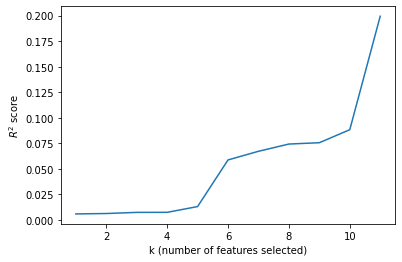

In [52]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(k_values, r2_scores)

plt.xlabel('k (number of features selected)')
plt.ylabel('$R^2$ score')

fig.set_facecolor('w')

plt.show()

In [58]:
skb = SelectKBest(k=12)
XKT_train = skb.fit_transform(XT_train, y_train)

model.fit(XKT_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

#Check metrics

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(XKT_train)
model_mae = mean_absolute_error(y_train, y_pred)
model_rmse = mean_squared_error(y_train, y_pred, squared=False)
model_r2s = r2_score(y_train, y_pred)

print('Model MAE:', model_mae)
print('Model RMSE:', model_rmse)
print('Model r^2:', model_r2s)

Model MAE: 193379.4138450368
Model RMSE: 260053.48361161558
Model r^2: 0.20438665898903152


#Validate the model

In [70]:
XT_val = ohe.transform(X_val)
XKT_val = skb.transform(XT_val)


model2 = Ridge(normalize=True)
model2.fit(XKT_val, y_val)
y_val_pred = model2.predict(XKT_val)

model2_mae = mean_absolute_error(y_val, y_val_pred)
model2_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
model2_r2s = r2_score(y_val, y_val_pred)

print('Validation MAE:', model2_mae)
print('Validation RMSE:', model2_rmse)
print('Validation $r^2$:', model2_r2s)

Validation MAE: 189955.72406564103
Validation RMSE: 261947.88924734556
Validation $r^2$: 0.22079733472448382
